# Spanish Translation A/B Test

## Goal
A/B tests play a huge role in website optimization. Analyzing A/B tests data is a very important
data scientist responsibility. Especially, data scientists have to make sure that results are
reliable, trustworthy, and conclusions can be drawn.
Furthermore, companies often run tens, if not hundreds, of A/B tests at the same time. Manually
analyzing all of them would require lot of time and people. Therefore, it is common practice to
look at the typical A/B test analysis steps and try to automate as much as possible. This frees
up time for the data scientists to work on more high level topics.
In this challenge, you will have to analyze results from an A/B test. Also, you will be asked to
design an algorithm to automate some steps.
## Challenge Description
Company XYZ is a worldwide e-commerce site with localized versions of the site.

A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than
any other Spanish-speaking country. She therefore went and talked to the international team in
charge of Spain And LatAm to see if they had any ideas about why that was happening.

Spain and LatAm country manager suggested that one reason could be translation. All Spanishspeaking
countries had the same translation of the site which was written by a Spaniard. They
agreed to try a test where each country would have its one translation written by a local. That is,
Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican
and so on. Obviously, nothing would change for users from Spain.
After they run the test however, they are really surprised cause the test is negative. I.e., it
appears that the non-localized translation was doing better!
You are asked to:

Confirm that the test is actually negative. That is, it appears that the old version of the
site with just one translation across Spain and LatAm performs better
Explain why that might be happening. Are the localized translations really worse?
7
If you identified what was wrong, design an algorithm that would return FALSE if the
same problem is happening in the future and TRUE if everything is good and the results
can be trusted.

## In this test, we are defining a one tailed Null hypothesis(H0): The test group performs better than or equally good as the control group. Alternative hypothesis(H1): The test group performs worse than the control group.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn import linear_model, preprocessing, tree, model_selection
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier, RandomForestRegressor, BaggingClassifier

In [2]:
test_table = pd.read_csv('test_table.csv')

In [3]:
user_table = pd.read_csv('user_table.csv')

In [4]:
merge_table = pd.merge(test_table, user_table, on='user_id')

In [5]:
merge_table.sample()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
58904,857984,2015-12-02,Ads,Web,ES,Google,Chrome,0,1,M,20,Mexico


In [6]:
merge_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 452867 entries, 0 to 452866
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           452867 non-null  int64 
 1   date              452867 non-null  object
 2   source            452867 non-null  object
 3   device            452867 non-null  object
 4   browser_language  452867 non-null  object
 5   ads_channel       181693 non-null  object
 6   browser           452867 non-null  object
 7   conversion        452867 non-null  int64 
 8   test              452867 non-null  int64 
 9   sex               452867 non-null  object
 10  age               452867 non-null  int64 
 11  country           452867 non-null  object
dtypes: int64(4), object(8)
memory usage: 44.9+ MB


In [7]:
merge_table.describe()

,user_id,conversion,test,age
count,452867.000000,452867.000000,452867.000000,452867.000000
mean,499944.805166,0.049560,0.476462,27.130740
std,288676.264784,0.217034,0.499446,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249819.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749543.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


Summary:
average conversion for all groups: 0.0496
test group/control group ratio: 0.476
average age: 27.131

In [8]:
merge_table[['source', 'device', 'browser_language', 'ads_channel', 'browser', 'sex', 'country']].describe()

,source,device,browser_language,ads_channel,browser,sex,country
count,452867,452867,452867,181693,452867,452867,452867
unique,3,2,3,5,7,2,17
top,Ads,Web,ES,Facebook,Android_App,M,Mexico
freq,181693,251316,377160,68358,154977,264485,128484


In [9]:
merge_table['source'].value_counts().tolist()

[181693, 180436, 90738]

In [10]:
for col in ['source', 'device', 'browser_language', 'ads_channel', 'browser', 'sex', 'country']:
    print(merge_table[col].value_counts()/merge_table[col].count())

Ads       0.401206
SEO       0.398430
Direct    0.200363
Name: source, dtype: float64
Web       0.554944
Mobile    0.445056
Name: device, dtype: float64
ES       0.832827
EN       0.139288
Other    0.027885
Name: browser_language, dtype: float64
Facebook    0.376228
Google      0.374880
Yahoo       0.150853
Bing        0.075237
Other       0.022802
Name: ads_channel, dtype: float64
Android_App    0.342213
Chrome         0.224839
IE             0.136146
Iphone_App     0.102843
Safari         0.090607
FireFox        0.089918
Opera          0.013434
Name: browser, dtype: float64
M    0.584024
F    0.415976
Name: sex, dtype: float64
Mexico         0.283712
Colombia       0.119373
Spain          0.114343
Argentina      0.103194
Peru           0.074340
Venezuela      0.070780
Chile          0.043582
Ecuador        0.035099
Guatemala      0.033398
Bolivia        0.024564
Honduras       0.018919
El Salvador    0.018052
Paraguay       0.016223
Nicaragua      0.014845
Costa Rica     0.011723
Uru

In [11]:
merge_table.loc[(merge_table.country == 'Mexico') & (merge_table.test == 0) & (merge_table.conversion == 1), 'conversion'].count()/merge_table.loc[(merge_table.country == 'Mexico') & (merge_table.test == 0), 'conversion'].count()

0.04949461913438926

conversion rate for Spain, with control group is 0.07971882121200417
conversion rate for Spain, with test group is nan
conversion rate for Mexico, with control group is 0.04949461913438926
conversion rate for Mexico, with test group is 0.05118630882924932


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


conversion rate for Venezuela, with control group is 0.05034367453093071
conversion rate for Venezuela, with test group is 0.04897830870795347
conversion rate for Bolivia, with control group is 0.04936936936936937
conversion rate for Bolivia, with test group is 0.04790096878363832
conversion rate for Colombia, with control group is 0.052089486119314826
conversion rate for Colombia, with test group is 0.05057096247960848
conversion rate for Uruguay, with control group is 0.012048192771084338
conversion rate for Uruguay, with test group is 0.012906695348211886
conversion rate for El Salvador, with control group is 0.053554040895813046
conversion rate for El Salvador, with test group is 0.04794688959921318
conversion rate for Nicaragua, with control group is 0.05264697279906405
conversion rate for Nicaragua, with test group is 0.05417675544794189
conversion rate for Peru, with control group is 0.04991404351176715
conversion rate for Peru, with test group is 0.05060427457284039
conversion 

<Figure size 1800x648 with 0 Axes>

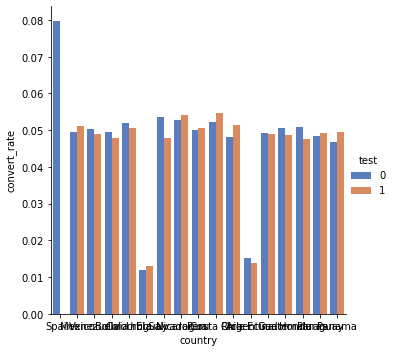

In [12]:
#Calculate the conversion rate for different countries:
testorcontrol = {0: 'control', 1: 'test'}
for each in merge_table['country'].unique():
    for group in testorcontrol:
        convert_rate = merge_table.loc[(merge_table.country == each) & (merge_table.test == group) & (merge_table.conversion == 1), 'conversion'].count()/merge_table.loc[(merge_table.country == each) & (merge_table.test == group), 'conversion'].count()
        merge_table.loc[(merge_table.country == each) & (merge_table.test == group), 'convert_rate'] = convert_rate
        print('conversion rate for {}, with {} group is {}'.format(each, testorcontrol[group], convert_rate))

fig = plt.figure(figsize=(25,9))   
sns.catplot(x='country', y='convert_rate', hue='test', data=merge_table, kind='bar', palette='muted')
plt.show()

<Figure size 1800x648 with 0 Axes>

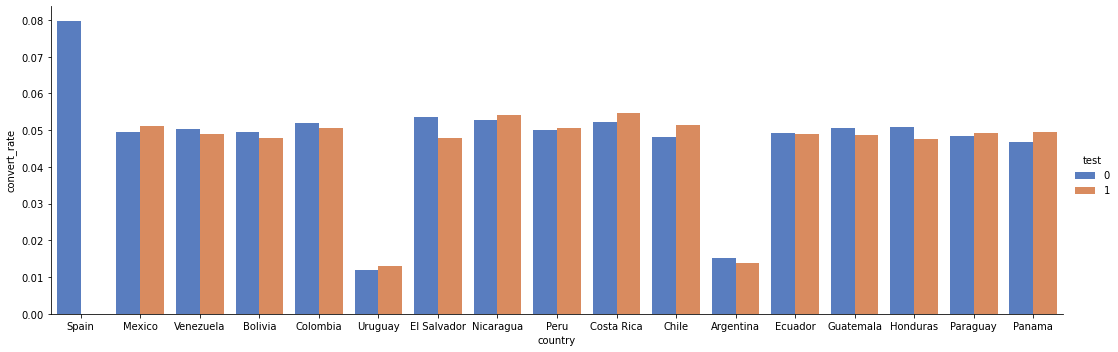

In [13]:
plt.figure(figsize=(25,9))   
sns.catplot(x='country', y='convert_rate', hue='test', data=merge_table, kind='bar', palette='muted', height=5, aspect=3)
plt.show()

### From the plot above, we see 8 out of 17 countries have improved conversion rate, while 8 out of 17 has worse conversion rate, and Spain has no test group. By counting the improved conversion rate for countries, we don't conclude a worse conversion rate for test group.

In [14]:
##Remove 'Spain' from the table to compare the control and test group.
temp_table = merge_table.drop(merge_table.loc[merge_table['country'] == 'Spain'].index)
control_conv = temp_table.loc[(temp_table['test'] == 0)&(temp_table['conversion'] == 1),'conversion'].count()/temp_table.loc[(temp_table['test'] == 0),'conversion'].count()
test_conv = temp_table.loc[(temp_table['test'] == 1)&(temp_table['conversion'] == 1),'conversion'].count()/temp_table.loc[(temp_table['test'] == 1),'conversion'].count()

print('Before removing \'spain\', the total number of user in control group is {}, test group is {}'.format(merge_table.loc[(merge_table['test'] == 0),'conversion'].count(), merge_table.loc[(merge_table['test'] == 1),'conversion'].count()))
print('After removing \'spain\', the total number of user in control group is {}, test group is {}'.format(temp_table.loc[(temp_table['test'] == 0),'conversion'].count(), temp_table.loc[(temp_table['test'] == 1),'conversion'].count()))
print('After removing \'spain\', the total conversion rate for control group is {}，for test group is {}'.format(control_conv, test_conv))

Before removing 'spain', the total number of user in control group is 237093, test group is 215774
After removing 'spain', the total number of user in control group is 185311, test group is 215774
After removing 'spain', the total conversion rate for control group is 0.04829179055749524，for test group is 0.043411161678422794


### All users from Spain are in the control group, once we remove the users from Spain, the control and test data are imbalanced!! The total conversion rate for the control group is 0.04829179055749524 is larger than the total conversion rate for the test group is 0.043411161678422794. From this metric, control group is better.

In [15]:
##How about we calculate the conversion change for the test group of each countries?
for each in merge_table['country'].unique():
    convert_change = (merge_table.loc[(merge_table['country'] == each) & (merge_table['test'] == 1), 'convert_rate'].mean() -\
    merge_table.loc[(merge_table['country'] == each) & (merge_table['test'] == 0), 'convert_rate'].mean()) / merge_table.loc\
    [(merge_table['country'] == each) & (merge_table['test'] == 0), 'convert_rate'].mean()
    merge_table.loc[(merge_table.country == each), 'convert_change'] = convert_change
    print('conversion change for {} is {}'.format(each, convert_change))

conversion change for Spain is nan
conversion change for Mexico is 0.03417926482607676
conversion change for Venezuela is -0.02712090119958048
conversion change for Bolivia is -0.029743150550391957
conversion change for Colombia is -0.02915221003002565
conversion change for Uruguay is 0.07125571390158647
conversion change for El Salvador is -0.10470080693832817
conversion change for Nicaragua is 0.029057371536184814
conversion change for Peru is 0.013828394025231047
conversion change for Costa Rica is 0.047497223059604514
conversion change for Chile is 0.06626551542193249
conversion change for Argentina is -0.08928178040995713
conversion change for Ecuador is -0.0033646822718772893
conversion change for Guatemala is -0.039406689828386625
conversion change for Honduras is -0.06612102951537217
conversion change for Paraguay is 0.015176452429745102
conversion change for Panama is 0.05502135582082975


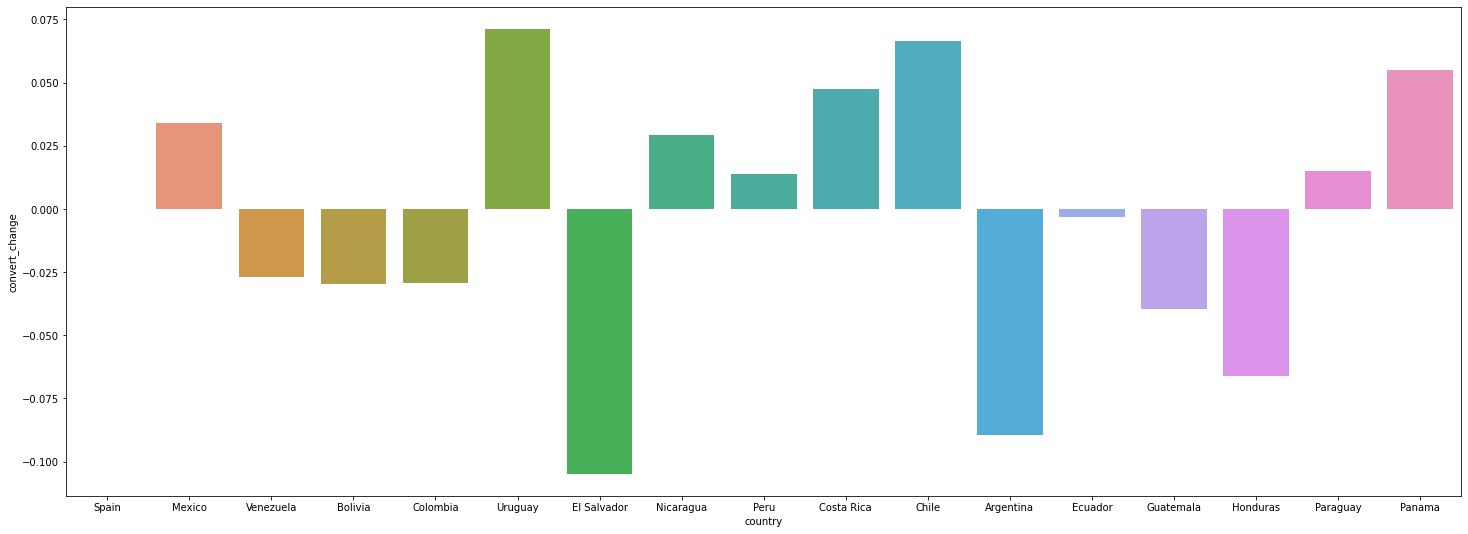

In [16]:
plt.figure(figsize=(25,9))   
sns.barplot(x='country', y='convert_change', data=merge_table)
plt.show()

In [17]:
temp = []
for each in merge_table['country'].unique():
    convert_change = (merge_table.loc[(merge_table['country'] == each) & (merge_table['test'] == 1), 'convert_rate'].mean() -\
    merge_table.loc[(merge_table['country'] == each) & (merge_table['test'] == 0), 'convert_rate'].mean()) / merge_table.loc\
    [(merge_table['country'] == each) & (merge_table['test'] == 0), 'convert_rate'].mean()
    merge_table.loc[(merge_table.country == each), 'convert_change'] = convert_change
    temp.append(convert_change)
    print('conversion change for {} is {}'.format(each, convert_change))
print(temp)
print(sum(temp[1:]))

conversion change for Spain is nan
conversion change for Mexico is 0.03417926482607676
conversion change for Venezuela is -0.02712090119958048
conversion change for Bolivia is -0.029743150550391957
conversion change for Colombia is -0.02915221003002565
conversion change for Uruguay is 0.07125571390158647
conversion change for El Salvador is -0.10470080693832817
conversion change for Nicaragua is 0.029057371536184814
conversion change for Peru is 0.013828394025231047
conversion change for Costa Rica is 0.047497223059604514
conversion change for Chile is 0.06626551542193249
conversion change for Argentina is -0.08928178040995713
conversion change for Ecuador is -0.0033646822718772893
conversion change for Guatemala is -0.039406689828386625
conversion change for Honduras is -0.06612102951537217
conversion change for Paraguay is 0.015176452429745102
conversion change for Panama is 0.05502135582082975
[nan, 0.03417926482607676, -0.02712090119958048, -0.029743150550391957, -0.029152210030025

### The sum of the convert change is negative, which means the unweighted convert change for the test group is also slightly worse than the control group.

In [18]:
!jt -t oceans16

## From the analysis above, we found the total converted rate for test group is worse. However, there are other insights uncovered:
    ### Comparing the test and control groups, we have equal number of countries with improved and degradated conversion rate
    ### The control group has much less users comparing to the test group after removing the users from Spain!!
    ### The control group has larger overall converted rate comparing to the test group. (0.048 vs 0.043)
    ### Without the bias of the number of users from different countries, the sum of the change of convert rate is slightly worse in test group than control group. (-0.057)
    ### The three countries with biggest improved conversion are: Uruguay, Chile and Panama.
    ### The three countries with biggest worsen conversion are: El Salvador, Argentina and Honduras
    With the user distribution, we can find out that we have considerably more users from the countries with biggest worsen conversion rate, therefore the overall conversion rate is negatively affected by those countries.
    Mexico         0.283712
    Colombia       0.119373
    Spain          0.114343
    Argentina      0.103194 #
    Peru           0.074340
    Venezuela      0.070780
    Chile          0.043582 *
    Ecuador        0.035099
    Guatemala      0.033398
    Bolivia        0.024564
    Honduras       0.018919 #
    El Salvador    0.018052 #
    Paraguay       0.016223
    Nicaragua      0.014845
    Costa Rica     0.011723
    Uruguay        0.009129 *
    Panama         0.008724 *

## A/B testing analysis
### The Null hypothesis for this A/B test is that the conversion rate for the test group will be better or equal than the control group assuming the confidence level = 95%/significance level = 0.05 for one-sided test, statistical power is 80%. let's gather some data to calculate the practical significance.

In [19]:
total_cont = temp_table.loc[temp_table['test'] == 0, 'conversion'].count()
conv_cont = temp_table.loc[(temp_table['test'] == 0)&(temp_table['conversion'] == 1),'conversion'].count()
print('total number for control group is {}, and total converted number for control group is {}'.format(total_cont, conv_cont))

total number for control group is 185311, and total converted number for control group is 8949


In [20]:
total_test = temp_table.loc[temp_table['test'] == 1, 'conversion'].count()
conv_test = temp_table.loc[(temp_table['test'] == 1)&(temp_table['conversion'] == 1),'conversion'].count()
print('total number for test group is {}, and total converted number for test group is {}'.format(total_test, conv_test))

total number for test group is 215774, and total converted number for test group is 9367


In [21]:
p_pool = (conv_cont + conv_test)/(total_cont + total_test)
SE_pool = np.sqrt(p_pool*(1-p_pool)*(1/total_cont + 1/total_test))
print('P_pool is {}, and SE_pool is {}'.format(p_pool, SE_pool))

P_pool is 0.04566613062069137, and SE_pool is 0.000661173334549995


In [22]:
d_hat = conv_test/total_test - conv_cont/total_cont
#assume the confidence level(one tailed): 95%  => z=1.65
margin = 1.65 * SE_pool
#confidence interval = (d_hat - margin, d_hat + margin)
conf_int_low = d_hat - margin
conf_int_high = d_hat + margin
print('confidence interal is between {} and {}'.format(conf_int_low, conf_int_high))

confidence interal is between -0.005971564881079937 and -0.003789692877064953


In [23]:
##is the test result significant? here is how we evaluate the result.
p_cont = conv_cont/total_cont
p_test = conv_test/total_test

print('p_cont is {}, p_test is {}'.format(p_cont, p_test))

SE_cont = np.sqrt(p_cont*(1-p_cont)/total_cont)
SE_test = np.sqrt(p_test*(1-p_test)/total_test)

print('SE_cont is {}, SE_test is {}'.format(SE_cont, SE_test))

Zscore = (p_test - p_cont)/np.sqrt(SE_cont**2 + SE_test**2)

print('Z score is ',Zscore)

p_cont is 0.04829179055749524, p_test is 0.043411161678422794
SE_cont is 0.000498009883851952, SE_test is 0.0004386961288573613
Z score is  -7.353913821211865


## Z score of -7.354 at a one-tailed hypothesis with significance level: 0.05 has p-value <0.00001, which rejects the H0, and the result is significant

https://www.socscistatistics.com/pvalues/normaldistribution.aspx

![jupyter](https://github.com/emoticn413/data_science/blob/master/spanish_translating_ab_test/2_sample_t_test.jpg?raw=true)

## Another diagram to show the result: with H0: Control group <= test group, HA: Control group > test group. z_score = -7.354 is much less than -1.65 (the z_score at significance level), which indicates that the result is statistically and practically significant and we can reject our Null hypothesis.

https://www.evanmiller.org/ab-testing/t-test.html

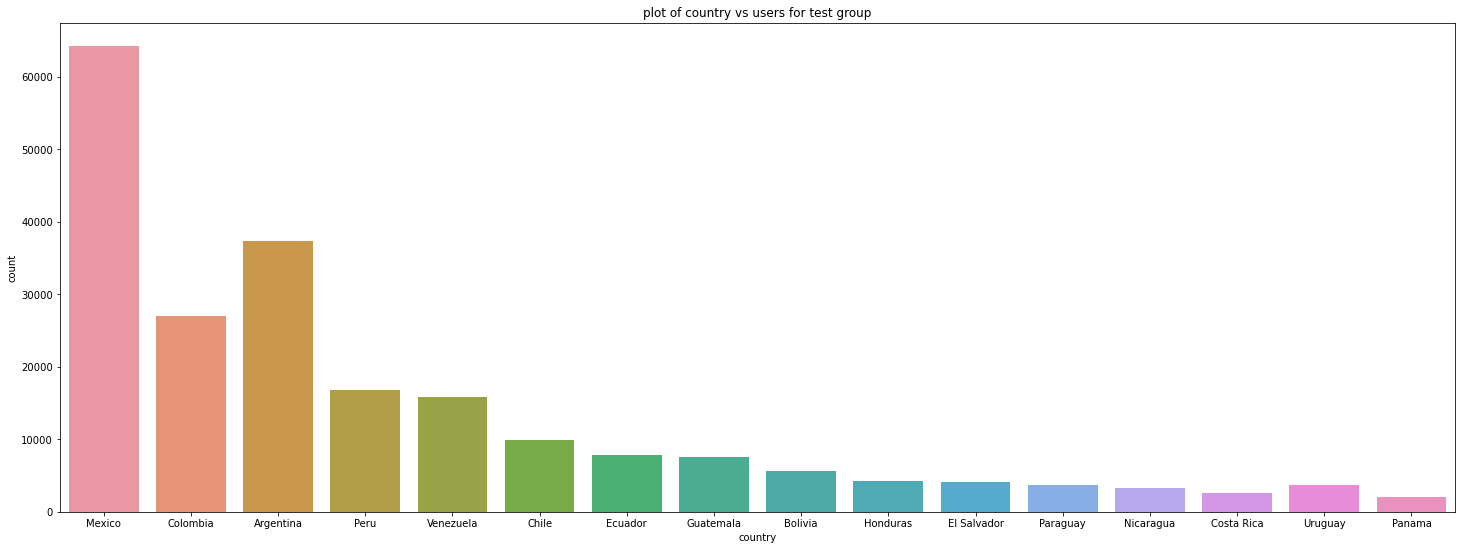

In [24]:
##dig more about the distribution for the control and test groups
plt.figure(figsize=(25,9))   
sns.countplot(x='country', data=temp_table.loc[temp_table['test'] == 1], order=temp_table['country'].value_counts().index)
plt.title('plot of country vs users for test group')
plt.show()

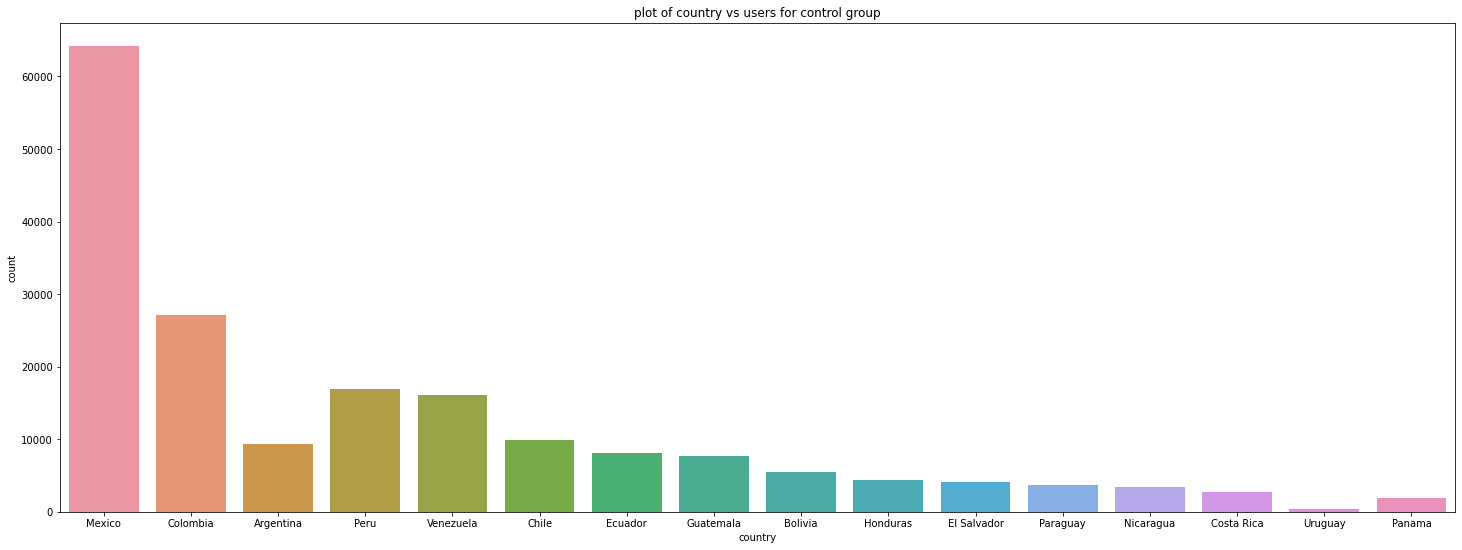

In [25]:
##dig more about the distribution for the control and test groups
plt.figure(figsize=(25,9))   
sns.countplot(x='country', data=temp_table.loc[temp_table['test'] == 0], order=temp_table['country'].value_counts().index)
plt.title('plot of country vs users for control group')
plt.show()

## IS the test group really worse in conversion rate than the control group??
# Not necessarily!
## The Argentina and Uruguay users has been imbalancedly distributed between the control and test groups!!The Argertina user has a decreased conversion rate while the Uruguay user has an increased conversion rate in the test group comparing to the control group. But the test group has way more Argentina users, which negatively affected the overall conversion rate!!

In [26]:
##test to remove the users from these two countries and calculate the conversion rate:
temp2_table = temp_table.drop(temp_table.loc[(temp_table['country'] == 'Argentina') | (temp_table['country'] == 'Uruguay')].index)

control_conv2 = temp2_table.loc[(temp2_table['test'] == 0)&(temp2_table['conversion'] == 1),'conversion'].count()/temp2_table.loc[(temp2_table['test'] == 0),'conversion'].count()
test_conv2 = temp2_table.loc[(temp2_table['test'] == 1)&(temp2_table['conversion'] == 1),'conversion'].count()/temp2_table.loc[(temp2_table['test'] == 1),'conversion'].count()

print('Before removing any country grouped users, the total number of user in control group is {}, test group is {}'.format(merge_table.loc[(merge_table['test'] == 0),'conversion'].count(), merge_table.loc[(merge_table['test'] == 1),'conversion'].count()))
print('After removing \'spain\', the total number of user in control group is {}, test group is {}'.format(temp_table.loc[(temp_table['test'] == 0),'conversion'].count(), temp_table.loc[(temp_table['test'] == 1),'conversion'].count()))
print('After removing \'spain\', \'Argentina\', \'Uruguay\' the total number of user in control group is {}, test group is {}'.format(temp2_table.loc[(temp2_table['test'] == 0),'conversion'].count(), temp2_table.loc[(temp2_table['test'] == 1),'conversion'].count()))
print('After removing \'spain\', the total conversion rate for control group is {}，for test group is {}'.format(control_conv2, test_conv2))

Before removing any country grouped users, the total number of user in control group is 237093, test group is 215774
After removing 'spain', the total number of user in control group is 185311, test group is 215774
After removing 'spain', 'Argentina', 'Uruguay' the total number of user in control group is 175540, test group is 174678
After removing 'spain', the total conversion rate for control group is 0.05014811438988265，for test group is 0.050412759477438486


In [27]:
total_cont2 = temp2_table.loc[temp2_table['test'] == 0, 'conversion'].count()
conv_cont2 = temp2_table.loc[(temp2_table['test'] == 0)&(temp2_table['conversion'] == 1),'conversion'].count()
print('total number for control group is {}, and total converted number for control group is {}'.format(total_cont2, conv_cont2))

total_test2 = temp2_table.loc[temp2_table['test'] == 1, 'conversion'].count()
conv_test2 = temp2_table.loc[(temp2_table['test'] == 1)&(temp2_table['conversion'] == 1),'conversion'].count()
print('total number for test group is {}, and total converted number for test group is {}'.format(total_test2, conv_test2))

total number for control group is 175540, and total converted number for control group is 8803
total number for test group is 174678, and total converted number for test group is 8806


## After removing Spain, Argentina, Uruguay from the data table, the split between the control and test group is more even.

In [28]:
##After removing users from \'spain\', \'Argentina\', \'Uruguay\' is the test result significant? here is how we evaluate the result.
p_cont2 = conv_cont2/total_cont2
p_test2 = conv_test2/total_test2

print('p_cont is {}, p_test is {}'.format(p_cont2, p_test2))

SE_cont2 = np.sqrt(p_cont2*(1-p_cont2)/total_cont2)
SE_test2 = np.sqrt(p_test2*(1-p_test2)/total_test2)

print('SE_cont is {}, SE_test is {}'.format(SE_cont2, SE_test2))

Zscore2 = (p_test2 - p_cont2)/np.sqrt(SE_cont2**2 + SE_test2**2)

print('Z score is ',Zscore2)

p_cont is 0.05014811438988265, p_test is 0.050412759477438486
SE_cont is 0.0005209154056286376, SE_test is 0.0005235022649556877
Z score is  0.35834660267840246


![t_test2](https://github.com/emoticn413/data_science/blob/master/spanish_translating_ab_test/2_sample_t_test_2.jpg?raw=true)

## From the analysis, the test group has better convert rate than the control group after removing Spain, Argentina, Uruguay. However, the Z_score = 0.358 is smaller than 1.65 (z_score at the significance level). For P_value, we have p_value = 1, which is bigger than 0.05. Therefore, H0 is failed to be rejected.

### What is the conversion vs date relationship?

In [29]:
temp2_table[temp2_table['test'] == 1].groupby(['date']).conversion.mean()

date
2015-11-30    0.051452
2015-12-01    0.047685
2015-12-02    0.051157
2015-12-03    0.050525
2015-12-04    0.050817
Name: conversion, dtype: float64

In [30]:
temp2_table[temp2_table['test'] == 0].groupby(['date']).conversion.mean()

date
2015-11-30    0.053032
2015-12-01    0.048181
2015-12-02    0.050185
2015-12-03    0.051098
2015-12-04    0.048999
Name: conversion, dtype: float64

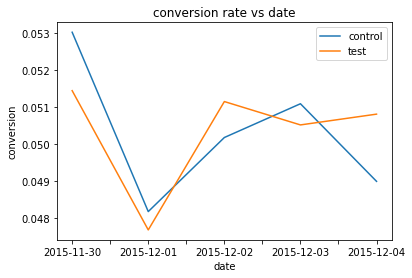

In [31]:
fig = temp2_table[temp2_table['test'] == 0].groupby(['date']).conversion.mean().plot()
temp2_table[temp2_table['test'] == 1].groupby(['date']).conversion.mean().plot(ax=fig)
plt.legend(['control', 'test'])
plt.title('conversion rate vs date')
plt.ylabel('conversion')
plt.show()

### From the conversion vs date plot, we can tell the two groups have the similar overall trend. However the test group has an fast increasing conversion rate than the control group after Dec 2nd, which is possible to be the transition period leads to larger conversion rate after the switching the translation style.

## With the testing period of 5 days, and sample size of 175,000 per group, averagely 35,000/day for each group. Let's double check the ab testing setup

In [32]:
from scipy.stats import norm, zscore

def sample_power_probtest(p1, p2, power=0.8, sig=0.05):
    z = norm.isf([sig]) #one-sided t test
    zp = -1 * norm.isf([power]) 
    d = (p1-p2)
    s =2*((p1+p2) /2)*(1-((p1+p2) /2))
    n = s * ((zp + z)**2) / (d**2)
    return int(round(n[0]))

sample_power_probtest(p_cont, p_cont*1.0375)

176368

## The current sample size is rougly good for Minimum Detectable Effect(MDE) of 3.75%. let's draw a plot to find out the relationship between MDE and sample size.

In [38]:
mde_analysis = []
for mde in [0.01, 0.03, 0.06, 0.09, 0.12, 0.15, 0.2]:
    samplesize = sample_power_probtest(p_cont, p_cont + mde)      #absolute MDE is usually used
    mde_analysis.append((samplesize, mde))
    
print(mde_analysis)

[(6238, 0.01), (815, 0.03), (248, 0.06), (129, 0.09), (83, 0.12), (59, 0.15), (39, 0.2)]


In [39]:
xs = [x[0] for x in mde_analysis]
ys = [x[1]*100 for x in mde_analysis]
xs2 = [x[0]/35000 for x in mde_analysis]

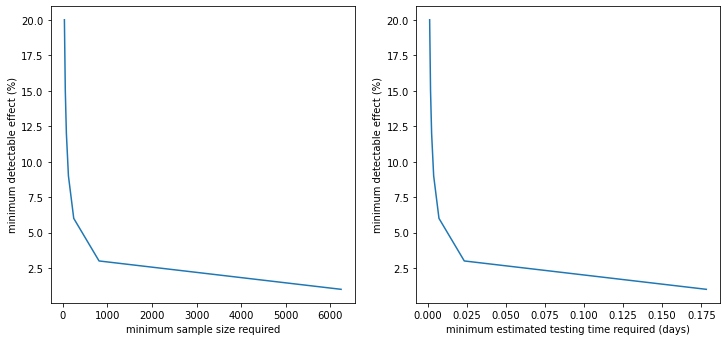

In [40]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.plot(xs, ys)
plt.xlabel('minimum sample size required')
plt.ylabel('minimum detectable effect (%)')
plt.subplot(2,2,2)
plt.plot(xs2, ys)
plt.xlabel('minimum estimated testing time required (days)')
plt.ylabel('minimum detectable effect (%)')
plt.show()

## The sample size is sufficient for MDE of 3.75% and larger. There is not a big issue with the sample size.

## Since the test group isn't practically significent after discarding the biased datasets. We could have designed an algorithm to detect the imbalanced traffic distribution for future test.

In [36]:
## Let's assume 4% maximum variance allowed traffic distribution differences between the test and control groups.

def sanity_check(table_in):
    newtable = table_in.loc[table_in['country'] != 'Spain']
    countrylist = newtable['country'].unique()
    for each in countrylist:
        print(each)
        testcount = newtable.loc[(newtable['test'] == 1) & (newtable['country'] == each), 'conversion'].count()
        controlcount = newtable.loc[(newtable['test'] == 0) & (newtable['country'] == each), 'conversion'].count()
        print(testcount, controlcount)
        if abs(testcount - controlcount)*2/(testcount + controlcount) >= 0.8:
            print('Imbalanced data selection is detected for {}'.format(each))
            return False
        else:
            continue
    return True

In [37]:
sanity_check(merge_table)

Mexico
64275 64209
Venezuela
15905 16149
Bolivia
5574 5550
Colombia
26972 27088
Uruguay
3719 415
Imbalanced data selection is detected for Uruguay


False

# Summary:
## Without any data treatment, the A/B test has suggested the test group is inferior than the control group, HOWEVER:
    1, The test group and control group has obvious data selection bias over Argentina and Uruguay, which has led to a biased conclusion. We could use the sanity check to QC the imbalanced traffic distribution issue in future.
    2, The time span for the test could be longer as we see the test group shows an increase trend of conversion rate while the control group shows the opposite. We need data covering a longer time to draw a more comprehensive conclusion.
    3, The current test shows some countries are subject to positive influence while some countries are opposite, we could consider launch the new translation version only for the countries where we see the positive impact.